### Practice 6:VAG model for dog & cat image(Deep learning 先從小批量試Run)
轉換灰階image
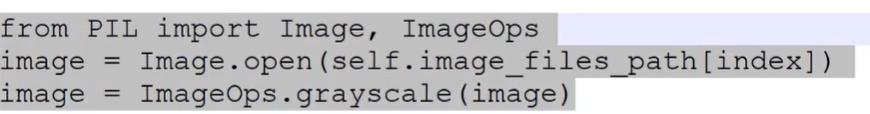

In [2]:
import torch
import torch.nn as nn
import torch.utils.data as data
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image, ImageOps
import os
import torch.nn.functional as F
from torchvision.utils import save_image
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))
class CustomImageDataset(Dataset):
    def read_data_set(self):
        all_img_files = []
        all_labels = []
        class_names = []
        for index, i in enumerate(os.listdir(self.data_set_path)):
            class_names.append(i)
            for j in os.listdir(self.data_set_path+'/'+i):
                all_img_files.append(self.data_set_path+'/'+i+'/'+j)
                all_labels.append(index)
        return all_img_files, all_labels, len(all_img_files), len(class_names)
    def __init__(self, data_set_path, transforms=None):
        self.data_set_path = data_set_path
        self.image_files_path, self.labels, self.length, self.num_classes = self.read_data_set()
        self.transforms = transforms
    def __getitem__(self, index):
        image = Image.open(self.image_files_path[index])
        image = ImageOps.grayscale(image)
        #image = image.convert("RGB")
        if self.transforms is not None:
            image = self.transforms(image)
        label = self.labels[index]
        return image, label
    def __len__(self):
        return self.length

Using cpu device


In [3]:
sample_dir = 'samples'
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

In [4]:
h_dim = 400
z_dim = 20
num_epochs = 100
batch_size = 128
learning_rate = 1e-3
image_size = 128 * 128
transforms_train = transforms.Compose([transforms.Resize((128, 128)),
                                       transforms.RandomRotation(10.),
                                       transforms.ToTensor()])
train_data_set = CustomImageDataset(data_set_path="./cat_dog/train", transforms=transforms_train)
data_loader = torch.utils.data.DataLoader(dataset=train_data_set, batch_size=batch_size, shuffle=True)

In [5]:
#VAG model
class VAE(nn.Module):
    def __init__(self, image_size=128*128, h_dim=400, z_dim=20):
        super(VAE, self).__init__()
        self.fc1 = nn.Linear(image_size, h_dim)
        self.fc2 = nn.Linear(h_dim, z_dim) 
        self.fc3 = nn.Linear(h_dim, z_dim) 
        self.fc4 = nn.Linear(z_dim, h_dim)
        self.fc5 = nn.Linear(h_dim, image_size)
    def encode(self, x):
        h = F.relu(self.fc1(x))
        return self.fc2(h), self.fc3(h)
    def reparameterize(self, mu, log_var):
        std = torch.exp(log_var/2)
        eps = torch.randn_like(std)
        return mu + eps * std
    def decode(self, z):
        h = F.relu(self.fc4(z))
        return F.sigmoid(self.fc5(h))
    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        x_reconst = self.decode(z)
        return x_reconst, mu, log_var
model = VAE().to(device)

In [6]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
for epoch in range(num_epochs):
    for i, (x, _) in enumerate(data_loader):
        x = x.to(device).view(-1, image_size)
        x_reconst, mu, log_var = model(x)
        reconst_loss = F.binary_cross_entropy(x_reconst, x, size_average=False)
        kl_div = - 0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
        loss = reconst_loss + kl_div
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if (i+1) % 2 == 0:
            print ("Epoch[{}/{}], Step [{}/{}], Reconst Loss: {:.4f}, KL Div: {:.4f}" 
                   .format(epoch+1, num_epochs, i+1, len(data_loader), reconst_loss.item(), kl_div.item()))
    with torch.no_grad():
        z = torch.randn(batch_size, z_dim).to(device)
        out = model.decode(z).view(-1, 1, 128, 128)
        save_image(out, os.path.join(sample_dir, 'sampled-{}.png'.format(epoch+1)))
        out, _, _ = model(x)
        x_concat = torch.cat([x.view(-1, 1, 128, 128), out.view(-1, 1, 128, 128)], dim=3)
        save_image(x_concat, os.path.join(sample_dir, 'reconst-{}.png'.format(epoch+1)))

C:\Users\mikal\anaconda3\envs\PyTorch_Class\lib\site-packages\torch\nn\functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
C:\Users\mikal\anaconda3\envs\PyTorch_Class\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Epoch[1/100], Step [2/4], Reconst Loss: 1557144.6250, KL Div: 21681.3027
Epoch[1/100], Step [4/4], Reconst Loss: 186182.8438, KL Div: 1717.0533
Epoch[2/100], Step [2/4], Reconst Loss: 1453763.0000, KL Div: 8009.0605
Epoch[2/100], Step [4/4], Reconst Loss: 182683.1875, KL Div: 905.1732
Epoch[3/100], Step [2/4], Reconst Loss: 1459968.1250, KL Div: 8393.1309
Epoch[3/100], Step [4/4], Reconst Loss: 181951.8438, KL Div: 612.6996
Epoch[4/100], Step [2/4], Reconst Loss: 1456156.7500, KL Div: 4373.7188
Epoch[4/100], Step [4/4], Reconst Loss: 179017.2812, KL Div: 289.9687
Epoch[5/100], Step [2/4], Reconst Loss: 1435484.2500, KL Div: 2357.0642
Epoch[5/100], Step [4/4], Reconst Loss: 178211.8906, KL Div: 378.4550
Epoch[6/100], Step [2/4], Reconst Loss: 1427069.2500, KL Div: 3599.1465
Epoch[6/100], Step [4/4], Reconst Loss: 176058.6094, KL Div: 449.4185
Epoch[7/100], Step [2/4], Reconst Loss: 1411378.0000, KL Div: 4377.5977
Epoch[7/100], Step [4/4], Reconst Loss: 175052.9688, KL Div: 444.6155
Epoc

Epoch[58/100], Step [2/4], Reconst Loss: 1259798.8750, KL Div: 6164.3071
Epoch[58/100], Step [4/4], Reconst Loss: 154298.9688, KL Div: 1014.2194
Epoch[59/100], Step [2/4], Reconst Loss: 1282747.7500, KL Div: 6830.1548
Epoch[59/100], Step [4/4], Reconst Loss: 158320.8125, KL Div: 958.3376
Epoch[60/100], Step [2/4], Reconst Loss: 1284165.1250, KL Div: 7053.1084
Epoch[60/100], Step [4/4], Reconst Loss: 164213.3594, KL Div: 881.9100
Epoch[61/100], Step [2/4], Reconst Loss: 1259959.2500, KL Div: 7876.6694
Epoch[61/100], Step [4/4], Reconst Loss: 154343.0000, KL Div: 811.0599
Epoch[62/100], Step [2/4], Reconst Loss: 1262194.2500, KL Div: 6899.2109
Epoch[62/100], Step [4/4], Reconst Loss: 163257.5938, KL Div: 788.9500
Epoch[63/100], Step [2/4], Reconst Loss: 1265648.0000, KL Div: 6863.0034
Epoch[63/100], Step [4/4], Reconst Loss: 150842.8438, KL Div: 853.8821
Epoch[64/100], Step [2/4], Reconst Loss: 1257607.6250, KL Div: 7133.7520
Epoch[64/100], Step [4/4], Reconst Loss: 156059.5625, KL Div: 

In [ ]:
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg 
import numpy as np
reconsPath = './samples/reconst-15.png'
Image = mpimg.imread(reconsPath)
plt.imshow(Image)
plt.axis('off')
plt.show()
genPath = './samples/sampled-15.png'
Image = mpimg.imread(genPath)
plt.imshow(Image) 
plt.axis('off') 
plt.show()